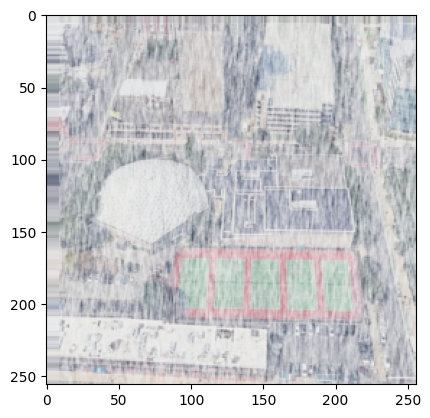

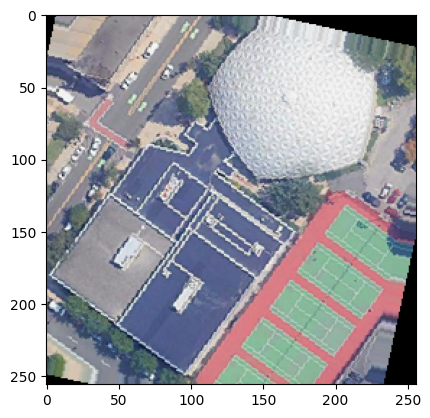

('rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'rain')
['rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'rain', 'rain']


In [10]:
from MLPN.loader import init_dataset_train, label2tensor, tensor2label
import os
import torch

from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show() 

data_dir = os.path.join(os.getcwd(), 'University-Release', 'train')
image_datasets, dataloaders, dataset_sizes = init_dataset_train(data_dir, batchsize=8, style='rain')
dataiter = iter(dataloaders['drone'])
img, img_s, label, weather = dataiter.next()
imshow(img[0])
imshow(img_s[0])
print(weather)
x = label2tensor(weather)
xx = tensor2label(x)
print(xx)

In [16]:
import os
import torch
import torch.nn as nn 
from torch.nn import functional as F
from utils.common import setup_seed 
from MLPN.loader import init_dataset_train
from utils.loader import  init_dataset_test, environments
from utils.metrics import metrics
from MLPN.model import CSWinTransv2_threeIn
from MLPN.utils import extract_feature, get_id, extract_feature, SAM, SupConLoss, one_LPN_output
from torch.autograd import Variable

from torch.optim import lr_scheduler
from tqdm.contrib import tzip

class MLPN_:
    def __init__(self, 
                 use_wandb=True,
                 wandb_key = '16c9a3f92163ef4df08841029e02fded0cd0cfed') -> None:
        # default parameters
        self.seed = 2024
        self.use_wandb = use_wandb # use wandb to monitor training instead of CLI
        self.wandb_key = wandb_key

        self.pytorch_version =  torch.__version__      
        self.w = 256
        self.h = 256

        # init
        setup_seed(self.seed)
        self.model_dir = os.path.join(os.getcwd(), 'model', 'MLPN')
        os.environ['TORCH_HOME']='./'   

    def train(self, 
              data_dir=None,
              style='mixed', 
              model_name='net',
              num_epochs=210,
              lr = 0.005,
              batchsize = 8,
              block = 4,
              checkpoint_interval = 10,
              checkpoint_start = 0,
              droprate = 0.75,
              ):
        if data_dir==None:
            data_dir = os.path.join(os.getcwd(), 'University-Release', 'train')
        image_datasets, dataloaders, dataset_sizes = init_dataset_train(data_dir, batchsize=batchsize, style=style)

        # fix setting that
        # ====================
        # LPN: true
        # SAM: 1
        # balance: true 
        # infonce: 1
        # decouple: false
        # only_decouple: false 
        # moving_avg: 1.0
        # warm_epoch: 0 --> No Warmup
        # extra_Google: false
        # select_id: false
        # normal: false --> dataloader give couple

        model = CSWinTransv2_threeIn(701, droprate=droprate, decouple=False, infonce=1)
        model = model.cuda()
        model.train(True) 

        ignored_params = list()
        for i in range(block):
            cls_name = 'classifier' + str(i)
            c = getattr(model, cls_name)
            ignored_params += list(map(id, c.parameters()))
        base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
        optim_params = [{'params': base_params, 'lr': 0.1 * lr}]
        for i in range(block):
            cls_name = 'classifier' + str(i)
            c = getattr(model, cls_name)
            optim_params.append({'params': c.parameters(), 'lr': lr})

        infonce = SupConLoss(temperature=0.1)
        # SAM = 1
        base_optimizer = torch.optim.SGD
        optimizer_ft = SAM(optim_params, base_optimizer, lr=lr, weight_decay=5e-4, momentum=0.9, nesterov=True)
        exp_lr_scheduler = lr_scheduler.MultiStepLR(optimizer_ft, milestones=[120, 180, 210], gamma=0.1)
        criterion = nn.CrossEntropyLoss()
        bestAcc, bestAp, bestEp = 0, 0, 0 

        for epoch in range(1, num_epochs+1):
            running_loss, running_corrects, running_corrects3 = 0.0, 0.0, 0.0
            ins_loss, dec_loss, on_loss, off_loss = 0.0, 0.0, 0.0, 0.0
            lossinfo1, lossinfo2 = 0.0, 0.0 
            optimizer = optimizer_ft
            # Iterate over data.
            for data, data3 in tzip(dataloaders['satellite'], dataloaders['drone']):
                # get the inputs
                inputs, inputs_d, labels, _ = data
                inputs3, inputs3_s, labels3, _ = data3
                now_batch_size, c, h, w = inputs.shape
                if now_batch_size < batchsize:  # skip the last batch
                    continue
                
                inputs = Variable(inputs.cuda().detach())
                inputs_d = Variable(inputs_d.cuda().detach())
                inputs3 = Variable(inputs3.cuda().detach())
                inputs3_s = Variable(inputs3_s.cuda().detach())
                labels = Variable(labels.cuda().detach())
                labels3 = Variable(labels3.cuda().detach())

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outs_c, outs_info = model(inputs) # decouple: false
                outs_d_c, outs_d_info = model(inputs_d) # balance: true and infonce: 1 

                outd_c, outd_info = model(inputs3)
                outs3_s_c, outs3_s_info = model(inputs3_s)

                # calculate loss 
                preds, loss = one_LPN_output(outs_c, labels, criterion, block)
                _, loss_d = one_LPN_output(outs_d_c, labels, criterion, block)
                loss = loss + loss_d
                preds3, loss3 = one_LPN_output(outd_c, labels3, criterion, block)
                _, loss3_s = one_LPN_output(outs3_s_c, labels3, criterion, block)
                loss3 = loss3 + loss3_s
                loss = (loss + loss3) / 2

                sate = F.normalize(outs_info, dim=1)
                drone = F.normalize(outd_info, dim=1)
                sate_ = F.normalize(outs_d_info, dim=1)
                drone_ = F.normalize(outs3_s_info, dim=1)
                features1 = torch.cat([sate.unsqueeze(1), sate_.unsqueeze(1)], dim=1)
                features2 = torch.cat([drone.unsqueeze(1), drone_.unsqueeze(1)], dim=1)
                loss_info = infonce(features1, labels)
                loss = loss + loss_info
                loss_info1 = infonce(features2, labels3)
                loss = loss + loss_info1

                # backward
                loss.backward()
                optimizer.first_step(zero_grad=True)

                # again
                outd_c, outd_info = model(inputs3)
                outs_c, outs_info = model(inputs)
                outs_d_c, outs_d_info = model(inputs_d)
                outs3_s_c, outs3_s_info = model(inputs3_s)

                preds, loss = one_LPN_output(outs_c, labels, criterion, block)
                _, loss_d = one_LPN_output(outs_d_c, labels, criterion, block)
                loss = loss + loss_d
                preds3, loss3 = one_LPN_output(outd_c, labels3, criterion, block)
                _, loss3_s = one_LPN_output(outs3_s_c, labels3, criterion, block)
                loss3 = loss3 + loss3_s
                loss = (loss + loss3) / 2

                sate = F.normalize(outs_info, dim=1)
                drone = F.normalize(outd_info, dim=1)
                sate_ = F.normalize(outs_d_info, dim=1)
                drone_ = F.normalize(outs3_s_info, dim=1)
                features1 = torch.cat([sate.unsqueeze(1), sate_.unsqueeze(1)], dim=1)
                features2 = torch.cat([drone.unsqueeze(1), drone_.unsqueeze(1)], dim=1)
                loss_info = infonce(features1, labels)
                loss = loss + loss_info
                loss_info1 = infonce(features2, labels3)
                loss = loss + loss_info1

                loss.backward()
                optimizer.second_step(zero_grad=True)

                # statistics
                running_loss += loss.item() * now_batch_size 
                running_corrects += float(torch.sum(preds == labels.data))
                running_corrects3 += float(torch.sum(preds3 == labels3.data))

            epoch_loss = running_loss / dataset_sizes['satellite']
            epoch_acc = running_corrects / dataset_sizes['satellite']
            epoch_acc3 = running_corrects3 / dataset_sizes['satellite']

            lossinfo1 += loss_info.item() * now_batch_size
            epoch_loss_info1 = lossinfo1 / dataset_sizes['satellite']

            print('{} Loss: {:.4f} Satellite_Acc: {:.4f} Drone_Acc: {:.4f} infoloss1: {:.4f} infoloss2: {:.4f}'.format(
                epoch, epoch_loss, epoch_acc,
                epoch_acc3, epoch_loss_info1, 0.00))
            
            exp_lr_scheduler.step()

            if epoch % checkpoint_interval == 0 and epoch > checkpoint_start:     
                save_filename = '{}_{:03d}.pth'.format(model_name, epoch)
                save_path = os.path.join(os.path.join(self.model_dir, save_filename))
                torch.save(model.cpu().state_dict(), save_path)
                model.cuda() # essential!   
        model_dir = self.model_dir 
        



    def train_multi_MLPNs(self, data_dir=None):
        # For competition
        self.model_dir = os.path.join(os.getcwd(), 'model', 'MLPNs')
        if not os.path.isdir(self.model_dir):
            os.mkdir(self.model_dir)
        for style in environments:
            print(style)
            # self.train(data_dir=data_dir, style=style, model_name=style)

        



    def test(self, pth=None, query='drone', gallery='satellite', multiple_scale=[1], batchsize=128, style='mixed'):
        # load data
        image_datasets, dataloaders, dataset_sizes = init_dataset_test(batchsize=batchsize, style=style, w=self.w, h=self.h)
        # init label
        gallery_name = 'gallery_' + gallery
        query_name = 'query_' + query 
        gallery_label = get_id(image_datasets[gallery_name].imgs)
        query_label = get_id(image_datasets[query_name].imgs)
        # print(dataset_sizes[gallery_name])
        # load model
        model_file = os.listdir(self.model_dir)[-1] if pth==None else pth + '.pth'
        print("load model: {}".format(model_file))
        model = CSWinTransv2_threeIn(701, droprate=0.75, decouple=False, infonce=1)
        

        try:
            model.load_state_dict(torch.load(os.path.join(self.model_dir, model_file))) 
        except:
            model = nn.DataParallel(model)
            model.load_state_dict(torch.load(os.path.join(self.model_dir, model_file))) 
            model = model.module

        if self.LPN:
            for i in range(self.block):
                cls_name = 'classifier'+str(i)
                c = getattr(model, cls_name)
                c.classifier = nn.Sequential()
        else:
            model.model.classifier.classifier = nn.Sequential()

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        model = model.to(device)
        # model.model = model.model.to(device)
        model = model.eval()

        # extract features
        with torch.no_grad():
            query_feature = extract_feature(model,dataloaders[query_name], view=query, ms=multiple_scale)
            gallery_feature = extract_feature(model,dataloaders[gallery_name], view=gallery, ms=multiple_scale)

        # calculate 
        m = metrics(query_feature, query_label, gallery_feature, gallery_label)
        print("Recall@1: {:.2f}".format(m[0]))
        print("Recall@5: {:.2f}".format(m[1]))
        print("Recall@10: {:.2f}".format(m[2]))
        print("Recall@top1: {:.2f}".format(m[3]))
        print("Recall@AP: {:.2f}".format(m[4]))
        # return m

        

In [17]:
m = MLPN_()
m.train_multi_MLPNs()

normal
dark
fog
rain
snow
fog_rain
fog_snow
rain_snow
light
wind


In [4]:
m = MLPN_()
m.batchsize=128
m.test()

951
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:12<00:00, 3013.90it/s]


Recall@1: 91.75
Recall@5: 97.59
Recall@10: 98.44
Recall@top1: 98.54
Recall@AP: 93.05


(tensor(91.7475),
 tensor(97.5882),
 tensor(98.4361),
 tensor(98.5418),
 93.05280791725373)

In [11]:
m = MLPN_()
m.batchsize=128

from utils.loader import environments 

for style in environments:
    print(style)
    m.test(style=style, pth='net_170')

normal
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2883.25it/s]


Recall@1: 94.07
Recall@5: 98.34
Recall@10: 98.79
Recall@top1: 98.86
Recall@AP: 95.03
dark
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:12<00:00, 2924.97it/s]


Recall@1: 93.92
Recall@5: 98.32
Recall@10: 98.85
Recall@top1: 98.90
Recall@AP: 94.91
fog
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:12<00:00, 2916.00it/s]


Recall@1: 93.38
Recall@5: 98.10
Recall@10: 98.71
Recall@top1: 98.79
Recall@AP: 94.45
rain
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2653.43it/s]


Recall@1: 92.05
Recall@5: 97.69
Recall@10: 98.52
Recall@top1: 98.63
Recall@AP: 93.31
snow
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2875.16it/s]


Recall@1: 90.97
Recall@5: 97.39
Recall@10: 98.27
Recall@top1: 98.40
Recall@AP: 92.41
fog_rain
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2890.64it/s]


Recall@1: 91.27
Recall@5: 97.38
Recall@10: 98.37
Recall@top1: 98.44
Recall@AP: 92.64
fog_snow
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:16<00:00, 2254.04it/s]


Recall@1: 89.94
Recall@5: 96.94
Recall@10: 98.05
Recall@top1: 98.17
Recall@AP: 91.52
rain_snow
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2752.66it/s]


Recall@1: 91.23
Recall@5: 97.36
Recall@10: 98.33
Recall@top1: 98.40
Recall@AP: 92.61
light
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2888.61it/s]


Recall@1: 90.40
Recall@5: 97.35
Recall@10: 98.34
Recall@top1: 98.44
Recall@AP: 91.96
wind
load model: net_170.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2909.69it/s]

Recall@1: 89.58
Recall@5: 96.65
Recall@10: 97.87
Recall@top1: 98.00
Recall@AP: 91.17


trained on original dataset

In [10]:
for style in environments:
    print(style)
    m.test(style=style, pth='net_170_')

normal
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2490.53it/s]


Recall@1: 93.71
Recall@5: 97.87
Recall@10: 98.54
Recall@top1: 98.60
Recall@AP: 94.69
dark
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2453.34it/s]


Recall@1: 92.21
Recall@5: 97.69
Recall@10: 98.48
Recall@top1: 98.57
Recall@AP: 93.45
fog
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2543.32it/s]


Recall@1: 80.77
Recall@5: 92.56
Recall@10: 95.07
Recall@top1: 95.37
Recall@AP: 83.45
rain
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2478.52it/s]


Recall@1: 57.52
Recall@5: 74.89
Recall@10: 80.74
Recall@top1: 81.47
Recall@AP: 61.56
snow
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2520.95it/s]


Recall@1: 40.22
Recall@5: 61.06
Recall@10: 69.79
Recall@top1: 70.82
Recall@AP: 45.19
fog_rain
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2391.87it/s]


Recall@1: 40.30
Recall@5: 57.55
Recall@10: 65.02
Recall@top1: 66.05
Recall@AP: 44.51
fog_snow
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2371.10it/s]


Recall@1: 22.02
Recall@5: 36.81
Recall@10: 44.76
Recall@top1: 45.89
Recall@AP: 25.85
rain_snow
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2413.84it/s]


Recall@1: 37.43
Recall@5: 56.25
Recall@10: 64.51
Recall@top1: 65.67
Recall@AP: 41.99
light
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2402.24it/s]


Recall@1: 85.42
Recall@5: 95.12
Recall@10: 97.03
Recall@top1: 97.24
Recall@AP: 87.59
wind
load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:15<00:00, 2452.96it/s]

Recall@1: 78.20
Recall@5: 91.55
Recall@10: 94.54
Recall@top1: 94.82
Recall@AP: 81.21


In [13]:
m.test(style='mixed', pth='net_170_')

load model: net_170_.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2526.40it/s]


Recall@1: 63.14
Recall@5: 76.16
Recall@10: 80.78
Recall@top1: 81.38
Recall@AP: 66.21
